## Get the actual EP and compare it to the bound for a bunch of different R matrices
- Cumulative EP is independent of R matrix in absence of external driving and can be calculated exactly
- System doesn't have to fully converge to calculate EP bound vs actual at each timestep
- Different R matrices and beta values will bring us closer or further from the bound

In [1]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import itertools
import scipy
import pickle
import thermo_tools


## Define global params
J = 1.
M = 1.
beta_array = np.linspace(0.05,0.95,4)
n = 4
N_R = 5 ## number of random R matrices

### Get initial distribution p_0 (random)
n_steps = 500+1
t_array = np.linspace(0,50,n_steps)  ## temporal evolution
dt = t_array[1]-t_array[0]
p_0 = np.random.rand(np.power(2,n))
p_0 = p_0/np.sum(p_0)
    
    

for beta in beta_array:
    print("Analyzing beta = ",beta)
    
    ## Get PI Matrix
    spin_configs = thermo_tools.all_configs(n)
    spin_df = pd.DataFrame(spin_configs)
    pi_vector = []
    E_array = []
    for config in spin_configs:
        H = thermo_tools.get_H(config,M,J)
        E_array.append(H)
        pi_vector.append(np.exp(-beta*H))
    pi_vector = pi_vector/np.sum(pi_vector) ## normalize
    PI = np.diag(pi_vector)

    ## Calculate change in Free Energy
    F1 = thermo_tools.get_F(spin_configs,p_0,M,J,beta)
    F2 = thermo_tools.get_F(spin_configs,pi_vector,M,J,beta)
    EP_exact = -beta*(F2-F1)
    print("Exact EP = ",EP_exact)

    ## Caclulate Exact EF = Delta E_avg / T
    E1_avg = 0.
    E2_avg = 0.
    for i in range(len(spin_configs)):
        config = spin_configs[i]
        E = thermo_tools.get_H(config,M,J)
        E1_avg = E1_avg + p_0[i]*E
        E2_avg = E2_avg + pi_vector[i]*E
    print("Exact EF = ",beta*(E2_avg-E1_avg),"\n")
    # print("\tAverage Initial Energy = ",E1_avg)
    # print("\tAverage Final Energy = ",E2_avg)

    # ## For each random R matrix, get the difference in EP (actual - bound) at each timestep
    results = []
    for i in range(N_R):

        print("\t Analyzing R Matrix ",i,"...")

        ## Create a random symmetric R matrix
        L = np.tril(np.random.rand(np.power(2,n),np.power(2,n)),0)  # random lower triangle
        U = np.triu(np.transpose(L),1)  # reflect the transpose for the upper triangle
        R = np.copy(L+U) # combine

        ## Get W matrix
        W = np.matmul(R,PI)-np.diag(np.matmul(R,pi_vector))
        W = np.transpose(W)

        # Make sure columns sum to zero
        for col in range(np.power(2,n)):
            if np.abs(np.sum(W[:,col])) > 1e-14:
                print("ERROR - cols should sum to one",np.sum(W[col,:]))

        # Make sure local detailed balance is satisfied
        for xx in range(n):
            for yy in range(n):
                W_ij = W[xx,yy]
                P_j = pi_vector[yy]
                W_ji = W[yy,xx]
                P_i = pi_vector[xx]
                if not np.isclose(W_ij*P_j,W_ji*P_i):
                    print("ERROR - Local Detailed Balance Violated!")


        ## Integrate forward in time
        def dp_dt(p_array,t):
            dp_array = np.zeros(len(W))
            for m in range(len(W)):
                dp_m = 0.
                for n in range(len(W)):
                    dp_m = dp_m + W[m][n]*p_array[n]
                dp_array[m]=dp_m
            if not np.isclose(np.sum(dp_array),0.0):
                print("ERROR PROB NOT CONSERVED!",np.sum(dp_array))
            return(dp_array)

        p_array = scipy.integrate.odeint(dp_dt,p_0,t_array)
        df = pd.DataFrame(p_array)

        ## Make sure we converged
        if np.isclose(p_array[-1],pi_vector,rtol=1e-16,atol=1e-6).all() == True:
            print("\t\t System converged.")
        else:
            print("\t\t System did not converge.")
            print(p_array[-1]-pi_vector)

        ## Get difference between EP bound and EP actual at each timestep
        EP_bounds = []
        EP_actuals = []
        differences = []
        for j in range(len(df)-1):
            p_1 = df.loc[j,:]
            p_2 = df.loc[j+1,:]

            ## Get EP Bound
            I_t0 = thermo_tools.I_Nstar(p_1,thermo_tools.get_units(n),n)
            I_tf = thermo_tools.I_Nstar(p_2,thermo_tools.get_units(n),n)
            EP_bound = -(I_tf-I_t0) ## this is the EP bound for this timestep
            EP_bounds.append(EP_bound)

            ## Get Actual EP
            EP_actual = thermo_tools.get_EP(W,p_1,dt)
            EP_actuals.append(EP_actual)

            ## Get the difference
            differences.append(EP_actual-EP_bound)
#             if EP_bound > EP_actual and not np.isclose(EP_bound,EP_actual):
#                 print("EP BOUND VIOLATED!",EP_bound,EP_actual)

        print("\t\t Results Appended.")
        results.append(differences)
    
    result_df = pd.DataFrame(results,columns=t_array[0:-1])

    result_df.to_csv('beta_'+str(beta)+'.csv')

    print("DONE")

Analyzing beta =  0.05
Exact EP =  0.135412977854471
Exact EF =  -0.017117271806918716 

	 Analyzing R Matrix  0 ...
		 System converged.
		 Results Appended.
	 Analyzing R Matrix  1 ...
		 System converged.
		 Results Appended.
	 Analyzing R Matrix  2 ...
		 System converged.
		 Results Appended.
	 Analyzing R Matrix  3 ...
		 System converged.
		 Results Appended.
	 Analyzing R Matrix  4 ...
		 System converged.
		 Results Appended.
DONE
Analyzing beta =  0.35
Exact EP =  0.7904442997164755
Exact EF =  -1.519661756560824 

	 Analyzing R Matrix  0 ...
		 System converged.
		 Results Appended.
	 Analyzing R Matrix  1 ...
		 System did not converge.
[ 2.27248379e-08 -3.31091996e-08 -4.35521139e-08  1.31130776e-06
 -1.98504849e-08 -1.02833300e-08 -5.40356158e-08  9.29075037e-08
  2.64133545e-08  1.75522553e-08  4.86423128e-07 -6.48902424e-08
 -6.26647001e-09 -1.94796343e-07 -1.08915064e-07 -1.42162998e-06]
		 Results Appended.
	 Analyzing R Matrix  2 ...
		 System converged.
		 Results A

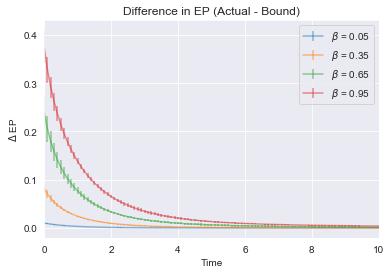

In [9]:
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

## Plot the difference between bound and actual as a function of time for each different beta
for beta in beta_array:
    final_df = pd.read_csv('beta_'+str(beta)+'.csv',header=0,index_col=0)
    
    means = []
    stddevs = []
    
    for i in final_df.columns:
        means.append(np.mean(final_df[i]))
        stddevs.append(np.std(final_df[i]))

    plt.errorbar(t_array[0:-1],means,stddevs,alpha=0.5,label=r'$\beta$ = {:.2f}'.format(beta))
plt.title('Difference in EP (Actual - Bound)')
plt.xlabel('Time')
plt.ylabel(r'$\Delta$ EP')
plt.xlim(0,10)
plt.legend()
plt.savefig('bound_vs_actual.pdf')
plt.show()

In [18]:
## Analyze single timestep
p_0 = p_array[0]
p_1 = p_array[1]

## Calculate EP exactly
EP_1 = thermo_tools.get_EP(W,p_0,dt)
print("Numerical EP at t_0 = ",EP_1)

## Calculate EF exactly
EF_1 = thermo_tools.get_EF(W,p_0,dt)
print("Numerical EF at t_0 = ",EF_1)

ds_numerical = EP_1+EF_1

S_0 = thermo_tools.get_S(p_0)
S_1 = thermo_tools.get_S(p_1)

ds_analytical = (S_1-S_0)

print("Numerical Entropy Change = ",ds_numerical)
print("Exact (Analytic) Entropy Change = ",ds_analytical)
print("Error = {:.2f}%".format(np.abs(ds_numerical-ds_analytical)/ds_analytical*100))

Numerical EP at t_0 =  0.0025236935496029916
Numerical EF at t_0 =  -0.00013607920322931927
Numerical Entropy Change =  0.0023876143463736725
Exact (Analytic) Entropy Change =  0.002366892463290249
Error = 0.88%


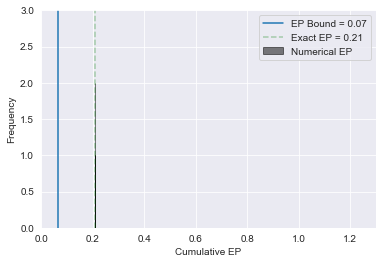

In [26]:
import seaborn as sns
sns.set_style('darkgrid')
plt.hist(EP_actual,bins=20,edgecolor='black',color='black',alpha=0.5,label='Numerical EP')
plt.ylim((0,3))
plt.xlim((0,1.3))
plt.axvline(EP_bound[0],label='EP Bound = {:.2f}'.format(EP_bound[0]))
plt.axvline(EP_exact,label='Exact EP = {:.2f}'.format(EP_exact),color='green',alpha=0.3,linestyle='dashed')
plt.xlabel('Cumulative EP')
plt.ylabel('Frequency')
plt.legend(loc='best')
# plt.savefig("various_Rmatrix3.pdf")
plt.show()

In [22]:
sampling_rate = [5000,2500,500,250,100,50,10]

cumulative_EPs = []

for s in sampling_rate:
    print("Sampling rate = ",s)
    dt = t_array[-1]/s
    indices = np.linspace(0,sampling_rate[0],s+1,dtype=int)
    new_array = np.copy(p_array[indices])
    cumulative_EP = 0.
    for i in range(len(new_array)):
        p_current = new_array[i]
        cumulative_EP = cumulative_EP + thermo_tools.get_EP(W,p_current,dt)
        print("\t",cumulative_EP)
    cumulative_EPs.append(cumulative_EP)
    
print("DONE")

Sampling rate =  5000
	 0.0025236935496029916
	 0.005005272401832314
	 0.0074460958559857855
	 0.009847428164574748
	 0.012210449492922147
	 0.014536265921556785
	 0.01682591670063251
	 0.01908038112907828
	 0.021300584410986756
	 0.02348740272393133
	 0.025641667701916396
	 0.027764170602520174
	 0.029855665469871517
	 0.031916872086983405
	 0.03394847862888557
	 0.0359511440261245
	 0.037925500108147
	 0.039872153545620084
	 0.04179168750815086
	 0.04368466320409831
	 0.045551621277483995
	 0.047393083285978535
	 0.04920955216333205
	 0.051001514192399476
	 0.05276943954229478
	 0.054513783161359006
	 0.05623498559877315
	 0.057933473764105695
	 0.05960966167042454
	 0.06126395106574444
	 0.0628967320188927
	 0.06450838347837953
	 0.06609927379254663
	 0.0676697611944696
	 0.06922019425471242
	 0.07075091230470233
	 0.07226224583320512
	 0.07375451685812628
	 0.07522803927564033
	 0.07668311918395725
	 0.0781200551655183
	 0.07953913859665228
	 0.08094065392665324
	 0.082324878937063

	 0.2070864493671517
	 0.20711518558245962
	 0.20714367086846663
	 0.2071719075141075
	 0.20719989778639633
	 0.20722764393064877
	 0.20725514817070148
	 0.20728241270912964
	 0.207309439727462
	 0.20733623138639362
	 0.20736278982599662
	 0.2073891171659284
	 0.2074152155056379
	 0.2074410869245697
	 0.20746673348236577
	 0.20749215721906547
	 0.20751736015530312
	 0.2075423442925037
	 0.2075671116130765
	 0.20759166408060664
	 0.20761600364004476
	 0.20764013221789468
	 0.207664051722399
	 0.20768776404370917
	 0.20771127105393986
	 0.2077345746074359
	 0.20775767654098218
	 0.20778057867397867
	 0.20780328280861388
	 0.20782579073003635
	 0.20784810420652433
	 0.20787022498965385
	 0.20789215481446482
	 0.2079138953996255
	 0.20793544844759526
	 0.2079568156447857
	 0.20797799866171984
	 0.20799899915319006
	 0.208019818758414
	 0.20804045910118904
	 0.2080609217900452
	 0.20808120841839636
	 0.20810132056468988
	 0.20812125979255486
	 0.20814102765094863
	 0.2081606256743019
	 0.20

	 0.2103858867345743
	 0.21038680151548808
	 0.21038770917138927
	 0.21038860975908166
	 0.210389503334904
	 0.21039038995473394
	 0.21039126967399194
	 0.21039214254764504
	 0.21039300863021076
	 0.2103938679757609
	 0.21039472063792516
	 0.21039556666989503
	 0.2103964061244274
	 0.21039723905384813
	 0.21039806551005588
	 0.21039888554452552
	 0.21039969920831175
	 0.2104005065520527
	 0.2104013076259733
	 0.21040210247988894
	 0.2104028911632087
	 0.2104036737249389
	 0.21040445021368645
	 0.21040522067766224
	 0.21040598516468437
	 0.21040674372218154
	 0.21040749639719628
	 0.21040824323638818
	 0.2104089842860372
	 0.21040971959204663
	 0.21041044919994653
	 0.21041117315489669
	 0.2104118915016897
	 0.2104126042847542
	 0.21041331154815773
	 0.2104140133356099
	 0.21041470969046452
	 0.2104154006557229
	 0.21041608627403716
	 0.21041676658771324
	 0.2104174416387137
	 0.21041811146866068
	 0.2104187761188387
	 0.2104194356301974
	 0.21042009004335457
	 0.21042073939859865
	 0.2

	 0.21050183595060842
	 0.21050186426988107
	 0.21050189238194372
	 0.21050192028833234
	 0.21050194799057134
	 0.2105019754901736
	 0.21050200278864087
	 0.21050202988746383
	 0.21050205678812203
	 0.21050208349208382
	 0.21050211000080657
	 0.21050213631573664
	 0.21050216243830952
	 0.21050218836994994
	 0.21050221411207187
	 0.21050223966607873
	 0.2105022650333633
	 0.21050229021530797
	 0.2105023152132847
	 0.21050234002865512
	 0.2105023646627707
	 0.2105023891169727
	 0.21050241339259235
	 0.21050243749095082
	 0.21050246141335943
	 0.2105024851611196
	 0.210502508735523
	 0.2105025321378516
	 0.21050255536937776
	 0.21050257843136422
	 0.21050260132506432
	 0.210502624051722
	 0.2105026466125718
	 0.21050266900883902
	 0.2105026912417398
	 0.2105027133124811
	 0.2105027352222609
	 0.2105027569722681
	 0.21050277856368277
	 0.21050279999767604
	 0.2105028212754103
	 0.21050284239803926
	 0.21050286336670793
	 0.21050288418255272
	 0.2105029048467016
	 0.21050292536027396
	 0.21

	 0.21050561746025032
	 0.21050561839790194
	 0.2105056193289263
	 0.21050562025337058
	 0.2105056211712816
	 0.21050562208270585
	 0.21050562298768943
	 0.2105056238862782
	 0.2105056247785176
	 0.21050562566445288
	 0.21050562654412888
	 0.21050562741759016
	 0.21050562828488095
	 0.21050562914604518
	 0.2105056300011264
	 0.21050563085016796
	 0.2105056316932128
	 0.21050563253030358
	 0.2105056333614827
	 0.2105056341867922
	 0.2105056350062738
	 0.21050563581996903
	 0.21050563662791902
	 0.21050563743016462
	 0.2105056382267464
	 0.21050563901770464
	 0.21050563980307935
	 0.21050564058291021
	 0.21050564135723668
	 0.21050564212609787
	 0.21050564288953263
	 0.21050564364757957
	 0.21050564440027697
	 0.21050564514766287
	 0.21050564588977502
	 0.2105056466266509
	 0.2105056473583277
	 0.2105056480848424
	 0.21050564880623168
	 0.21050564952253198
	 0.21050565023377943
	 0.21050565094000992
	 0.21050565164125912
	 0.2105056523375624
	 0.21050565302895494
	 0.21050565371547156
	 

	 0.2105057457782596
	 0.2105057458140519
	 0.21050574584959564
	 0.21050574588489254
	 0.21050574591994436
	 0.2105057459547528
	 0.21050574598931954
	 0.21050574602364627
	 0.2105057460577347
	 0.21050574609158648
	 0.21050574612520326
	 0.2105057461585867
	 0.2105057461917384
	 0.21050574622466
	 0.21050574625735313
	 0.21050574628981938
	 0.21050574632206034
	 0.21050574635407757
	 0.21050574638587266
	 0.21050574641744715
	 0.21050574644880257
	 0.21050574647994047
	 0.21050574651086235
	 0.2105057465415697
	 0.21050574657206403
	 0.2105057466023468
	 0.2105057466324195
	 0.21050574666228358
	 0.21050574669194053
	 0.21050574672139175
	 0.21050574675063866
	 0.2105057467796827
	 0.2105057468085253
	 0.21050574683716783
	 0.2105057468656117
	 0.21050574689385826
	 0.21050574692190893
	 0.21050574694976504
	 0.21050574697742794
	 0.210505747004899
	 0.21050574703217953
	 0.21050574705927086
	 0.2105057470861743
	 0.2105057471128912
	 0.21050574713942277
	 0.21050574716577036
	 0.210

	 0.2105057508115053
	 0.2105057508124616
	 0.2105057508134113
	 0.21050575081435452
	 0.21050575081529127
	 0.21050575081622158
	 0.2105057508171455
	 0.2105057508180631
	 0.21050575081897444
	 0.21050575081987952
	 0.21050575082077838
	 0.21050575082167108
	 0.21050575082255768
	 0.2105057508234382
	 0.2105057508243127
	 0.2105057508251812
	 0.21050575082604372
	 0.21050575082690037
	 0.21050575082775114
	 0.21050575082859607
	 0.21050575082943523
	 0.21050575083026862
	 0.21050575083109632
	 0.21050575083191833
	 0.2105057508327347
	 0.2105057508335455
	 0.21050575083435075
	 0.21050575083515047
	 0.21050575083594472
	 0.21050575083673354
	 0.21050575083751694
	 0.21050575083829495
	 0.21050575083906764
	 0.21050575083983505
	 0.2105057508405972
	 0.21050575084135412
	 0.21050575084210585
	 0.21050575084285245
	 0.2105057508435939
	 0.2105057508443303
	 0.21050575084506162
	 0.21050575084578796
	 0.21050575084650933
	 0.21050575084722573
	 0.21050575084793724
	 0.21050575084864387
	

	 0.21050575094759325
	 0.21050575094761728
	 0.21050575094764115
	 0.21050575094766488
	 0.21050575094768845
	 0.21050575094771184
	 0.21050575094773508
	 0.21050575094775817
	 0.2105057509477811
	 0.21050575094780385
	 0.21050575094782648
	 0.21050575094784893
	 0.21050575094787125
	 0.2105057509478934
	 0.2105057509479154
	 0.21050575094793725
	 0.21050575094795895
	 0.21050575094798052
	 0.21050575094800192
	 0.21050575094802318
	 0.2105057509480443
	 0.21050575094806528
	 0.21050575094808613
	 0.21050575094810683
	 0.2105057509481274
	 0.2105057509481478
	 0.21050575094816806
	 0.2105057509481882
	 0.21050575094820823
	 0.2105057509482281
	 0.21050575094824783
	 0.21050575094826743
	 0.21050575094828688
	 0.2105057509483062
	 0.2105057509483254
	 0.21050575094834448
	 0.2105057509483634
	 0.21050575094838223
	 0.2105057509484009
	 0.21050575094841947
	 0.2105057509484379
	 0.21050575094845622
	 0.2105057509484744
	 0.21050575094849247
	 0.2105057509485104
	 0.21050575094852822
	 0

	 0.21050575095093457
	 0.21050575095093577
	 0.21050575095093693
	 0.2105057509509381
	 0.21050575095093926
	 0.21050575095094043
	 0.21050575095094157
	 0.2105057509509427
	 0.21050575095094384
	 0.21050575095094495
	 0.21050575095094606
	 0.21050575095094717
	 0.21050575095094828
	 0.21050575095094937
	 0.21050575095095045
	 0.21050575095095153
	 0.2105057509509526
	 0.21050575095095367
	 0.21050575095095472
	 0.21050575095095578
	 0.2105057509509568
	 0.21050575095095783
	 0.21050575095095886
	 0.21050575095095989
	 0.21050575095096088
	 0.21050575095096188
	 0.21050575095096288
	 0.21050575095096388
	 0.21050575095096485
	 0.21050575095096583
	 0.2105057509509668
	 0.21050575095096777
	 0.2105057509509687
	 0.21050575095096966
	 0.2105057509509706
	 0.21050575095097154
	 0.21050575095097246
	 0.21050575095097337
	 0.2105057509509743
	 0.2105057509509752
	 0.21050575095097612
	 0.210505750950977
	 0.2105057509509779
	 0.2105057509509788
	 0.21050575095097968
	 0.21050575095098054
	

	 0.21050575095109955
	 0.21050575095109958
	 0.2105057509510996
	 0.21050575095109963
	 0.21050575095109966
	 0.2105057509510997
	 0.21050575095109972
	 0.21050575095109975
	 0.21050575095109977
	 0.2105057509510998
	 0.21050575095109983
	 0.21050575095109986
	 0.21050575095109988
	 0.2105057509510999
	 0.21050575095109994
	 0.21050575095109997
	 0.2105057509511
	 0.21050575095110002
	 0.21050575095110005
	 0.21050575095110008
	 0.2105057509511001
	 0.21050575095110013
	 0.21050575095110016
	 0.2105057509511002
	 0.21050575095110022
	 0.21050575095110025
	 0.21050575095110027
	 0.2105057509511003
	 0.21050575095110033
	 0.21050575095110036
	 0.21050575095110038
	 0.2105057509511004
	 0.21050575095110044
	 0.21050575095110047
	 0.2105057509511005
	 0.21050575095110052
	 0.21050575095110055
	 0.21050575095110058
	 0.2105057509511006
	 0.21050575095110063
	 0.21050575095110066
	 0.2105057509511007
	 0.21050575095110072
	 0.21050575095110075
	 0.21050575095110077
	 0.2105057509511008
	 0.

	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.2105057509511042
	 0.210505750

	 0.20268683965614126
	 0.20284552235383463
	 0.2030013058443363
	 0.20315424590407619
	 0.20330439717294413
	 0.20345181317895
	 0.2035965463623024
	 0.2037386480989207
	 0.20387816872339487
	 0.20401515755140692
	 0.20414966290162775
	 0.20428173211710257
	 0.2044114115861491
	 0.2045387467640375
	 0.204663782192897
	 0.2047865615205066
	 0.2049071275193615
	 0.2050255221053005
	 0.205141786355705
	 0.20525596052728023
	 0.20536808407342896
	 0.20547819566122774
	 0.2055863331880152
	 0.20569253379760202
	 0.20579683389611186
	 0.20589926916871862
	 0.20599987459272107
	 0.20609868445497112
	 0.20619573236489955
	 0.20629105126869274
	 0.20638467346314832
	 0.2064766306092171
	 0.20656695374523953
	 0.20665567329988418
	 0.20674281910479542
	 0.20682842040695754
	 0.20691250588078255
	 0.20699510363999396
	 0.2070762412500861
	 0.20715594573920879
	 0.20723424360898632
	 0.2073111608453517
	 0.20738672292914312
	 0.20746095484646868
	 0.20753388109884502
	 0.2076055257131153
	 0.2076

	 0.2117588608309601
	 0.2117591470739027
	 0.2117594290393317
	 0.2117597067922633
	 0.21175998039670527
	 0.21176024991567277
	 0.21176051541120403
	 0.2117607769443756
	 0.21176103457531778
	 0.21176128836323657
	 0.21176153836642567
	 0.21176178464227768
	 0.21176202724729834
	 0.21176226623712044
	 0.2117625016665176
	 0.21176273358941783
	 0.21176296205891668
	 0.21176318712729053
	 0.21176340884600928
	 0.2117636272657491
	 0.21176384243640486
	 0.21176405440710236
	 0.21176426322621036
	 0.2117644689413525
	 0.21176467159941892
	 0.21176487124657764
	 0.211765067928286
	 0.21176526168930163
	 0.2117654525736934
	 0.21176564062485217
	 0.21176582588550136
	 0.2117660083977123
	 0.21176618820291485
	 0.211766365341903
	 0.21176653985484503
	 0.21176671178129314
	 0.21176688116019307
	 0.2117670480298936
	 0.2117672124281558
	 0.2117673743921622
	 0.21176753395852577
	 0.21176769116329874
	 0.21176784604198143
	 0.21176799862953063
	 0.21176814896036822
	 0.21176829706838932
	 0.2

	 0.21177824013476543
	 0.2117782410021503
	 0.2117782418573825
	 0.21177824270063342
	 0.211778243532072
	 0.21177824435186476
	 0.2117782451601759
	 0.21177824595716727
	 0.2117782467429984
	 0.21177824751782653
	 0.21177824828180672
	 0.21177824903509176
	 0.21177824977783233
	 0.21177825051017693
	 0.21177825123227195
	 0.2117782519442617
	 0.2117782526462884
	 0.21177825333849234
	 0.21177825402101172
	 0.2117782546939828
	 0.21177825535753989
	 0.2117782560118154
	 0.2117782566569399
	 0.21177825729304198
	 0.21177825792024854
	 0.21177825853868473
	 0.21177825914847395
	 0.21177825974973782
	 0.21177826034259625
	 0.21177826092716748
	 0.21177826150356802
	 0.21177826207191278
	 0.21177826263231503
	 0.21177826318488643
	 0.21177826372973707
	 0.2117782642669755
	 0.21177826479670867
	 0.21177826531904206
	 0.21177826583407966
	 0.21177826634192398
	 0.2117782668426761
	 0.2117782673364356
	 0.21177826782330073
	 0.2117782683033683
	 0.21177826877673378
	 0.21177826924349127
	 0

	 0.21177830235533995
	 0.21177830235556847
	 0.21177830235579387
	 0.2117783023560162
	 0.2117783023562355
	 0.21177830235645181
	 0.2117783023566652
	 0.21177830235687567
	 0.21177830235708328
	 0.21177830235728806
	 0.21177830235749004
	 0.21177830235768927
	 0.2117783023578858
	 0.21177830235807965
	 0.21177830235827086
	 0.21177830235845946
	 0.21177830235864548
	 0.21177830235882897
	 0.21177830235900996
	 0.21177830235918849
	 0.21177830235936457
	 0.21177830235953826
	 0.2117783023597096
	 0.21177830235987857
	 0.21177830236004525
	 0.21177830236020967
	 0.21177830236037185
	 0.2117783023605318
	 0.2117783023606896
	 0.21177830236084522
	 0.21177830236099873
	 0.21177830236115017
	 0.21177830236129952
	 0.21177830236144685
	 0.21177830236159217
	 0.21177830236173553
	 0.21177830236187692
	 0.2117783023620164
	 0.21177830236215398
	 0.21177830236228967
	 0.21177830236242354
	 0.21177830236255557
	 0.2117783023626858
	 0.21177830236281428
	 0.211778302362941
	 0.21177830236306602

	 0.21177830237212314
	 0.21177830237212333
	 0.21177830237212353
	 0.21177830237212372
	 0.21177830237212392
	 0.2117783023721241
	 0.2117783023721243
	 0.2117783023721245
	 0.21177830237212467
	 0.21177830237212483
	 0.211778302372125
	 0.21177830237212517
	 0.21177830237212533
	 0.2117783023721255
	 0.21177830237212567
	 0.21177830237212583
	 0.211778302372126
	 0.21177830237212616
	 0.21177830237212633
	 0.2117783023721265
	 0.21177830237212664
	 0.21177830237212678
	 0.21177830237212691
	 0.21177830237212705
	 0.2117783023721272
	 0.21177830237212733
	 0.21177830237212747
	 0.2117783023721276
	 0.21177830237212775
	 0.21177830237212789
	 0.21177830237212802
	 0.21177830237212816
	 0.2117783023721283
	 0.21177830237212844
	 0.21177830237212858
	 0.21177830237212872
	 0.21177830237212883
	 0.21177830237212894
	 0.21177830237212905
	 0.21177830237212916
	 0.21177830237212927
	 0.21177830237212938
	 0.2117783023721295
	 0.2117783023721296
	 0.21177830237212972
	 0.21177830237212983
	 

	 0.22046665276874328
	 0.22060459850656475
	 0.22073131583359776
	 0.22084775121314362
	 0.22095476814683707
	 0.22105315476574766
	 0.2211436306846332
	 0.22122685321845842
	 0.221303423004495
	 0.22137388909147743
	 0.22143875355532006
	 0.22149847568267844
	 0.22155347575894532
	 0.2216041385145882
	 0.22165081625392447
	 0.221693831694769
	 0.22173348053900477
	 0.22177003382317617
	 0.22180374005397496
	 0.22183482714962346
	 0.2218635042033631
	 0.22188996309602604
	 0.22191437996388522
	 0.22193691653491984
	 0.22195772134481695
	 0.22197693085125214
	 0.2219946704493272
	 0.22201105539713656
	 0.22202619166007628
	 0.22204017668510836
	 0.22205310010742563
	 0.2220650443954543
	 0.22207608544068969
	 0.22208629309868197
	 0.22209573168309363
	 0.22210446041962464
	 0.22211253385703403
	 0.2221200022489532
	 0.22212691190153694
	 0.22213330549133856
	 0.22213922235765174
	 0.2221446987709757
	 0.22214976817897242
	 0.22215446143182607
	 0.22215880698861895
	 0.2221628311074127


	 0.23584089425842739
	 0.2358468197382026
	 0.23585190761406816
	 0.2358562782235852
	 0.23586003430254593
	 0.23586326360356463
	 0.23586604113288065
	 0.23586843103110164
	 0.2358704881825232
	 0.23587225957240476
	 0.23587378544789686
	 0.23587510029930478
	 0.23587623369356917
	 0.23587721099672607
	 0.23587805397693157
	 0.2358787813220673
	 0.23587940908602953
	 0.23587995106248907
	 0.23588041910906093
	 0.23588082342394529
	 0.23588117277966222
	 0.23588147472678028
	 0.23588173576612767
	 0.23588196149600515
	 0.2358821567402407
	 0.2358823256560343
	 0.2358824718271948
	 0.2358825983447789
	 0.23588270787509744
	 0.23588280271903486
	 0.2358828848628124
	 0.2358829560212204
	 0.23588301767540099
	 0.23588307110493062
	 0.2358831174154743
	 0.2358831575629347
	 0.23588319237368854
	 0.23588322256212033
	 0.2358832487461657
	 0.23588327146069815
	 0.23588329116853607
	 0.23588330827016082
	 0.23588332311240354
	 0.23588333599565486
	 0.2358833471800396
	 0.23588335689084355
	 

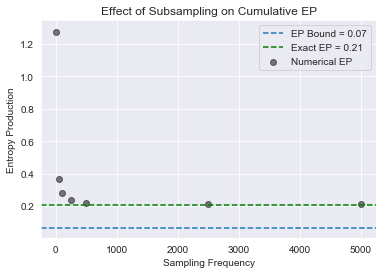

In [30]:
plt.axhline(EP_bound[0],label='EP Bound = {:.2f}'.format(EP_bound[0]),linestyle='dashed')
plt.axhline(EP_exact,label='Exact EP = {:.2f}'.format(EP_exact),linestyle='dashed',color='green')
plt.scatter(sampling_rate,cumulative_EPs,alpha=0.5,color='black',label='Numerical EP')
plt.xlabel('Sampling Frequency')
plt.ylabel('Entropy Production')
plt.title('Effect of Subsampling on Cumulative EP')
plt.legend(loc='best')
plt.savefig('subsample3.pdf')
plt.show()

#### Numerical agrees with exact within about 1% for high sampling frequency